In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

import librosa
import librosa.display
import os
import logging
import json
import numpy as np
import csv
from tqdm import tqdm
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import soundfile as sf
from torchvision import datasets
from math import floor, ceil

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation


import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

2023-11-18 01:34:41.849209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import torch
print(torch.__version__)
%matplotlib inline

2.1.0


In [3]:
path = "../Data"

In [4]:
import gc
gc.collect()

46

In [5]:
seed = 42
np.random.seed(seed)

path = "../Data"
path_audio_files = path + "/genres_original/"
path_imgs = "../Data/images_original/"
batch_size = 32
hop_length = 512
n_fft = 2048
device = 'cuda' if torch.cuda.is_available() else 'cpu'

genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(497664, 512)  # Adjust the input features to match your data
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [7]:
import torch
from torchvision import datasets, transforms

# Define Transforms
train_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

test_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

# Paths to the train, validation, and test folders
train_path = '../Data/train/images_original'  # Update this path
val_path = '../Data/val/images_original'      # Update this path
test_path = '../Data/test/images_original'    # Update this path

# Load the data from folders
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_path, transform=test_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

# Batch Size (Define it if not already defined)
batch_size = 32  # Update this as per your requirement

# Make DataLoaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Classes
classes = train_dataset.classes
print(f"Classes: {classes}")

# Print the number of samples in each set
print(f"Number of Train Samples: {len(train_dataset)}")
print(f"Number of Validation Samples: {len(val_dataset)}")
print(f"Number of Test Samples: {len(test_dataset)}")

Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Number of Train Samples: 800
Number of Validation Samples: 100
Number of Test Samples: 99


In [8]:
# Number of classes (adjust this based on your dataset)
num_classes = len(classes)

# Create the model instance
model = SimpleCNN(num_classes)

# Define the Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, print_every, num_epoch, save_at_epoch, checkpoint_path=None):

    steps = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    start_epoch = 0

    model.to(device)

    # Load checkpoint if provided
    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        train_accuracies = checkpoint.get('train_accuracies', [])
        val_accuracies = checkpoint.get('val_accuracies', [])

    for epoch in tqdm(range(start_epoch, num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()

        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
        
        train_accuracy = correct_train / total_train * 100
        train_accuracies.append(train_accuracy)

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        correct_val, total_val = 0, 0
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
                
                correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                total_val += labels.size(0)

        # Validation Accuracy
        val_accuracy = correct_val / total_val * 100
        val_accuracies.append(val_accuracy)

        # Validation Loss
        val_loss = val_loss / len(val_dataloader)
        val_losses.append(val_loss)

        print(f'Val loss {val_loss:.3f}.', end=' ')
        print(f'Val acc {val_accuracy:.3f}.', end=' ')
        print(f'Took {time() - iter_time:.3f} seconds')
        iter_time = time()
        
        print(f'Epoch took {time() - start_time}')
        # Save checkpoint

        if epoch % save_at_epoch == 0 or epoch == num_epoch - 1:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }
            torch.save(checkpoint, f'../Models/SimpleCNN/checkpoint_{epoch}.pth')

    return model, train_losses, val_losses, train_accuracies, val_accuracies


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1]/[50]. Batch [25]/[25]. Train loss 49.501. Train acc 10.750. Val loss 2.302. Val acc 10.000. Took 99.882 seconds
Epoch took 99.88210868835449


  2%|▏         | 1/50 [02:00<1:38:40, 120.83s/it]

Epoch [2]/[50]. Batch [25]/[25]. Train loss 1.149. Train acc 9.500. 

  4%|▍         | 2/50 [03:39<1:26:15, 107.83s/it]

Val loss 2.290. Val acc 10.000. Took 98.683 seconds
Epoch took 98.68289351463318
Epoch [3]/[50]. Batch [25]/[25]. Train loss 0.759. Train acc 10.000. 

  6%|▌         | 3/50 [05:17<1:20:59, 103.39s/it]

Val loss 2.263. Val acc 10.000. Took 98.105 seconds
Epoch took 98.10461497306824
Epoch [4]/[50]. Batch [25]/[25]. Train loss 0.563. Train acc 10.250. 

  8%|▊         | 4/50 [06:53<1:17:03, 100.50s/it]

Val loss 2.268. Val acc 21.000. Took 96.073 seconds
Epoch took 96.07255625724792
Epoch [5]/[50]. Batch [25]/[25]. Train loss 0.449. Train acc 13.750. 

 10%|█         | 5/50 [08:32<1:15:01, 100.04s/it]

Val loss 2.254. Val acc 19.000. Took 99.221 seconds
Epoch took 99.22141981124878
Epoch [6]/[50]. Batch [25]/[25]. Train loss 0.373. Train acc 15.125. 

 12%|█▏        | 6/50 [10:10<1:12:43, 99.17s/it] 

Val loss 2.247. Val acc 13.000. Took 97.477 seconds
Epoch took 97.47673511505127
Epoch [7]/[50]. Batch [25]/[25]. Train loss 0.319. Train acc 16.000. 

 14%|█▍        | 7/50 [11:55<1:12:20, 100.94s/it]

Val loss 2.240. Val acc 14.000. Took 104.580 seconds
Epoch took 104.58043074607849
Epoch [8]/[50]. Batch [25]/[25]. Train loss 0.278. Train acc 17.000. 

 16%|█▌        | 8/50 [13:35<1:10:34, 100.81s/it]

Val loss 2.238. Val acc 12.000. Took 100.544 seconds
Epoch took 100.54449486732483
Epoch [9]/[50]. Batch [25]/[25]. Train loss 0.246. Train acc 17.750. 

 18%|█▊        | 9/50 [15:10<1:07:32, 98.84s/it] 

Val loss 2.243. Val acc 14.000. Took 94.504 seconds
Epoch took 94.50399732589722
Epoch [10]/[50]. Batch [25]/[25]. Train loss 0.222. Train acc 19.250. 

 20%|██        | 10/50 [16:48<1:05:50, 98.76s/it]

Val loss 2.230. Val acc 19.000. Took 98.588 seconds
Epoch took 98.58831930160522
Epoch [11]/[50]. Batch [25]/[25]. Train loss 0.200. Train acc 19.875. Val loss 2.224. Val acc 20.000. Took 102.827 seconds
Epoch took 102.82715129852295


 22%|██▏       | 11/50 [18:51<1:09:01, 106.19s/it]

Epoch [12]/[50]. Batch [25]/[25]. Train loss 0.182. Train acc 22.375. 

 24%|██▍       | 12/50 [20:28<1:05:22, 103.22s/it]

Val loss 2.240. Val acc 12.000. Took 96.388 seconds
Epoch took 96.38751268386841
Epoch [13]/[50]. Batch [25]/[25]. Train loss 0.168. Train acc 20.625. 

 26%|██▌       | 13/50 [22:01<1:01:48, 100.24s/it]

Val loss 2.218. Val acc 12.000. Took 93.397 seconds
Epoch took 93.3969841003418
Epoch [14]/[50]. Batch [25]/[25]. Train loss 0.154. Train acc 21.375. 

 28%|██▊       | 14/50 [23:36<59:10, 98.62s/it]   

Val loss 2.217. Val acc 17.000. Took 94.888 seconds
Epoch took 94.88848900794983
Epoch [15]/[50]. Batch [25]/[25]. Train loss 0.142. Train acc 25.750. 

 30%|███       | 15/50 [25:14<57:27, 98.50s/it]

Val loss 2.219. Val acc 17.000. Took 98.212 seconds
Epoch took 98.21189761161804
Epoch [16]/[50]. Batch [25]/[25]. Train loss 0.132. Train acc 24.375. 

 32%|███▏      | 16/50 [26:58<56:45, 100.17s/it]

Val loss 2.230. Val acc 15.000. Took 104.042 seconds
Epoch took 104.0418643951416
Epoch [17]/[50]. Batch [25]/[25]. Train loss 0.123. Train acc 27.625. 

 34%|███▍      | 17/50 [28:38<55:02, 100.07s/it]

Val loss 2.224. Val acc 22.000. Took 99.834 seconds
Epoch took 99.83436107635498
Epoch [18]/[50]. Batch [25]/[25]. Train loss 0.114. Train acc 26.375. 

 36%|███▌      | 18/50 [30:20<53:37, 100.56s/it]

Val loss 2.255. Val acc 11.000. Took 101.700 seconds
Epoch took 101.70045232772827
Epoch [19]/[50]. Batch [25]/[25]. Train loss 0.108. Train acc 27.000. 

 38%|███▊      | 19/50 [32:05<52:43, 102.05s/it]

Val loss 2.269. Val acc 11.000. Took 105.517 seconds
Epoch took 105.51745271682739
Epoch [20]/[50]. Batch [25]/[25]. Train loss 0.102. Train acc 28.125. 

 40%|████      | 20/50 [33:51<51:34, 103.15s/it]

Val loss 2.232. Val acc 15.000. Took 105.721 seconds
Epoch took 105.7208149433136
Epoch [21]/[50]. Batch [25]/[25]. Train loss 0.095. Train acc 29.875. Val loss 2.287. Val acc 13.000. Took 99.597 seconds
Epoch took 99.59727501869202


 42%|████▏     | 21/50 [35:50<52:07, 107.83s/it]

Epoch [22]/[50]. Batch [25]/[25]. Train loss 0.089. Train acc 31.875. 

 44%|████▍     | 22/50 [37:25<48:33, 104.06s/it]

Val loss 2.261. Val acc 18.000. Took 95.282 seconds
Epoch took 95.28164172172546
Epoch [23]/[50]. Batch [25]/[25]. Train loss 0.085. Train acc 32.500. 

 46%|████▌     | 23/50 [39:02<45:50, 101.87s/it]

Val loss 2.274. Val acc 12.000. Took 96.765 seconds
Epoch took 96.7646234035492
Epoch [24]/[50]. Batch [25]/[25]. Train loss 0.079. Train acc 34.625. 

 48%|████▊     | 24/50 [41:40<51:27, 118.75s/it]

Val loss 2.319. Val acc 14.000. Took 158.108 seconds
Epoch took 158.107825756073
Epoch [25]/[50]. Batch [25]/[25]. Train loss 0.075. Train acc 34.750. 

 50%|█████     | 25/50 [44:33<56:19, 135.19s/it]

Val loss 2.339. Val acc 13.000. Took 173.544 seconds
Epoch took 173.54388642311096
Epoch [26]/[50]. Batch [25]/[25]. Train loss 0.071. Train acc 35.625. 

 52%|█████▏    | 26/50 [46:28<51:36, 129.04s/it]

Val loss 2.350. Val acc 12.000. Took 114.676 seconds
Epoch took 114.67596650123596
Epoch [27]/[50]. Batch [25]/[25]. Train loss 0.067. Train acc 37.125. 

 54%|█████▍    | 27/50 [47:59<45:03, 117.53s/it]

Val loss 2.319. Val acc 15.000. Took 90.691 seconds
Epoch took 90.6914701461792
Epoch [28]/[50]. Batch [25]/[25]. Train loss 0.064. Train acc 38.875. 

 56%|█████▌    | 28/50 [49:28<40:00, 109.11s/it]

Val loss 2.357. Val acc 13.000. Took 89.451 seconds
Epoch took 89.45121479034424
Epoch [29]/[50]. Batch [25]/[25]. Train loss 0.060. Train acc 40.375. 

 58%|█████▊    | 29/50 [51:03<36:41, 104.82s/it]

Val loss 2.384. Val acc 14.000. Took 94.830 seconds
Epoch took 94.82993364334106
Epoch [30]/[50]. Batch [25]/[25]. Train loss 0.057. Train acc 43.125. 

 60%|██████    | 30/50 [52:34<33:31, 100.55s/it]

Val loss 2.425. Val acc 14.000. Took 90.582 seconds
Epoch took 90.58160591125488
Epoch [31]/[50]. Batch [25]/[25]. Train loss 0.055. Train acc 42.250. Val loss 2.490. Val acc 15.000. Took 99.191 seconds
Epoch took 99.1906566619873


 62%|██████▏   | 31/50 [54:32<33:29, 105.76s/it]

Epoch [32]/[50]. Batch [25]/[25]. Train loss 0.052. Train acc 44.500. 

 64%|██████▍   | 32/50 [56:11<31:10, 103.92s/it]

Val loss 2.533. Val acc 11.000. Took 99.621 seconds
Epoch took 99.62077331542969
Epoch [33]/[50]. Batch [25]/[25]. Train loss 0.050. Train acc 44.750. 

 66%|██████▌   | 33/50 [57:51<29:07, 102.77s/it]

Val loss 2.470. Val acc 16.000. Took 100.070 seconds
Epoch took 100.0700831413269
Epoch [34]/[50]. Batch [25]/[25]. Train loss 0.047. Train acc 44.625. 

 68%|██████▊   | 34/50 [59:30<27:04, 101.53s/it]

Val loss 2.528. Val acc 15.000. Took 98.638 seconds
Epoch took 98.63782715797424
Epoch [35]/[50]. Batch [25]/[25]. Train loss 0.045. Train acc 45.500. 

 70%|███████   | 35/50 [1:01:08<25:06, 100.44s/it]

Val loss 2.534. Val acc 17.000. Took 97.898 seconds
Epoch took 97.89795136451721
Epoch [36]/[50]. Batch [25]/[25]. Train loss 0.044. Train acc 46.750. 

 72%|███████▏  | 36/50 [1:02:50<23:32, 100.87s/it]

Val loss 2.451. Val acc 17.000. Took 101.868 seconds
Epoch took 101.8675811290741
Epoch [37]/[50]. Batch [25]/[25]. Train loss 0.041. Train acc 47.375. 

 74%|███████▍  | 37/50 [1:04:29<21:44, 100.37s/it]

Val loss 2.601. Val acc 11.000. Took 99.198 seconds
Epoch took 99.19760346412659
Epoch [38]/[50]. Batch [25]/[25]. Train loss 0.039. Train acc 50.375. 

 76%|███████▌  | 38/50 [1:06:08<20:01, 100.13s/it]

Val loss 2.569. Val acc 15.000. Took 99.563 seconds
Epoch took 99.5634355545044
Epoch [39]/[50]. Batch [25]/[25]. Train loss 0.036. Train acc 52.250. 

 78%|███████▊  | 39/50 [1:07:47<18:16, 99.66s/it] 

Val loss 2.658. Val acc 15.000. Took 98.558 seconds
Epoch took 98.5575635433197
Epoch [40]/[50]. Batch [25]/[25]. Train loss 0.035. Train acc 52.500. 

 80%|████████  | 40/50 [1:09:25<16:32, 99.21s/it]

Val loss 2.707. Val acc 15.000. Took 98.181 seconds
Epoch took 98.18124532699585
Epoch [41]/[50]. Batch [25]/[25]. Train loss 0.033. Train acc 55.875. Val loss 2.732. Val acc 15.000. Took 99.937 seconds
Epoch took 99.93661093711853


 82%|████████▏ | 41/50 [1:11:22<15:41, 104.61s/it]

Epoch [42]/[50]. Batch [25]/[25]. Train loss 0.032. Train acc 56.000. 

 84%|████████▍ | 42/50 [1:13:01<13:43, 102.91s/it]

Val loss 2.777. Val acc 13.000. Took 98.922 seconds
Epoch took 98.92234539985657
Epoch [43]/[50]. Batch [25]/[25]. Train loss 0.030. Train acc 56.750. 

 86%|████████▌ | 43/50 [1:14:39<11:48, 101.24s/it]

Val loss 2.785. Val acc 12.000. Took 97.347 seconds
Epoch took 97.34693503379822
Epoch [44]/[50]. Batch [25]/[25]. Train loss 0.028. Train acc 59.125. 

 88%|████████▊ | 44/50 [1:16:16<10:00, 100.14s/it]

Val loss 2.824. Val acc 14.000. Took 97.571 seconds
Epoch took 97.57124781608582
Epoch [45]/[50]. Batch [25]/[25]. Train loss 0.027. Train acc 60.375. 

 90%|█████████ | 45/50 [1:17:50<08:10, 98.13s/it] 

Val loss 2.939. Val acc 11.000. Took 93.426 seconds
Epoch took 93.42573952674866
Epoch [46]/[50]. Batch [25]/[25]. Train loss 0.025. Train acc 60.125. 

 92%|█████████▏| 46/50 [1:19:23<06:27, 96.76s/it]

Val loss 2.962. Val acc 11.000. Took 93.588 seconds
Epoch took 93.58764743804932
Epoch [47]/[50]. Batch [25]/[25]. Train loss 0.024. Train acc 61.750. 

 94%|█████████▍| 47/50 [1:20:57<04:47, 95.80s/it]

Val loss 3.061. Val acc 12.000. Took 93.546 seconds
Epoch took 93.54607510566711
Epoch [48]/[50]. Batch [25]/[25]. Train loss 0.023. Train acc 63.625. 

 96%|█████████▌| 48/50 [1:22:30<03:10, 95.16s/it]

Val loss 2.995. Val acc 19.000. Took 93.654 seconds
Epoch took 93.65426540374756
Epoch [49]/[50]. Batch [25]/[25]. Train loss 0.022. Train acc 65.250. 

 98%|█████████▊| 49/50 [1:24:08<01:35, 95.96s/it]

Val loss 3.157. Val acc 12.000. Took 97.845 seconds
Epoch took 97.84527683258057
Epoch [50]/[50]. Batch [25]/[25]. Train loss 0.020. Train acc 67.250. 

100%|██████████| 50/50 [1:25:42<00:00, 102.85s/it]

Val loss 3.295. Val acc 10.000. Took 93.913 seconds
Epoch took 93.91275143623352


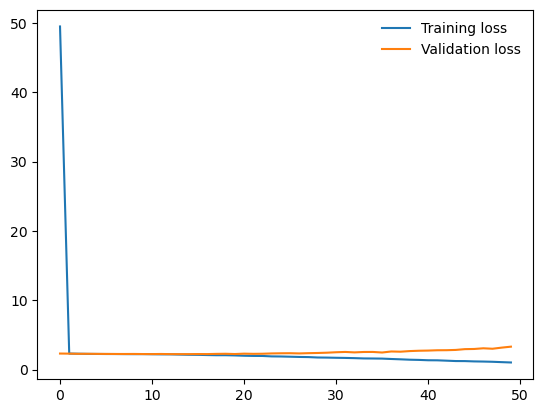

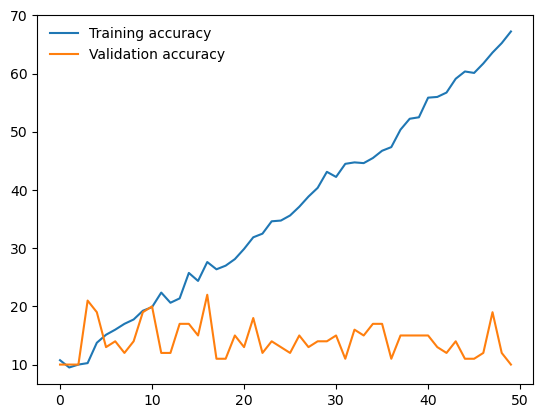

In [10]:
from time import time
print_every = 25
num_epoch = 50

model, train_losses, val_losses, train_accuracies, val_accuracies = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    print_every=print_every,
    save_at_epoch=10,
    num_epoch=num_epoch
)

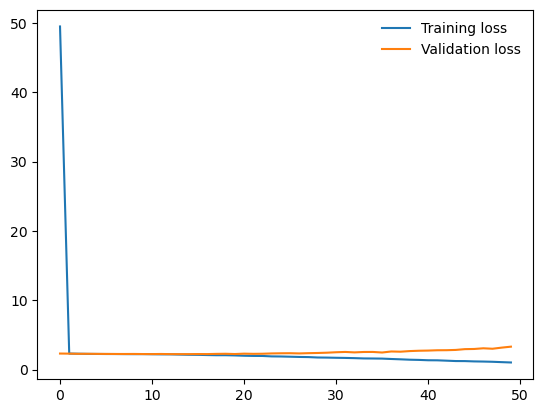

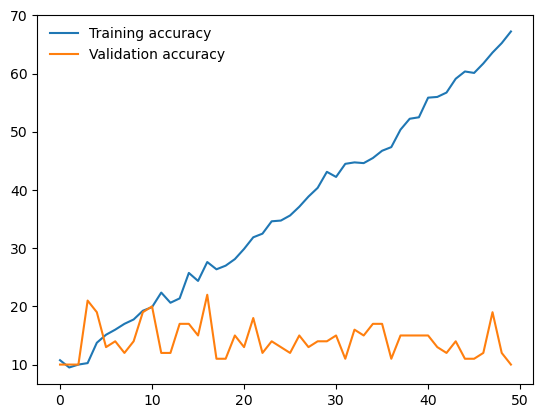

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('../Output/SimpleCNN/simplecnn_loss.png')
plt.show()

plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.savefig('../Output/SimpleCNN/simplecnn_accuracy.png')
plt.show()

In [10]:
# Load the model
CHECKPOINT_PATH = '../Models/SimpleCNN/checkpoint_40.pth'
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint.get('train_accuracies', [])
val_accuracies = checkpoint.get('val_accuracies', [])

In [14]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'device' is already defined (e.g., 'cuda' or 'cpu')
# Assuming 'resnet' is your trained model
# Assuming 'classes' maps indices to genre names

y_test = []
y_pred = []

# Iterate through the test dataloader
for img, label in test_dataloader:
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(img)
    
    final_preds = torch.max(prediction, dim=1)[1]
    y_test.extend(label.tolist())
    y_pred.extend(final_preds.cpu().tolist())

# Map predicted indices back to class names
y_pred_labels = [classes[pred] for pred in y_pred]

# Calculate class-wise accuracy
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
classwise_accuracy = {}

conf_matrix = confusion_matrix(y_test, y_pred)
for i in range(len(y_test)):
    label = y_test[i]
    pred = y_pred[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(len(classes)):
    classwise_accuracy[classes[i]] = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
print(f'Overall Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %')
# Print Class-wise accuracy
for class_name, accuracy in classwise_accuracy.items():
    print(f'Accuracy of {class_name} : {accuracy:.2f} %')

Overall Test Accuracy: 24.24 %
Accuracy of blues : 20.00 %
Accuracy of classical : 10.00 %
Accuracy of country : 10.00 %
Accuracy of disco : 20.00 %
Accuracy of hiphop : 10.00 %
Accuracy of jazz : 11.11 %
Accuracy of metal : 50.00 %
Accuracy of pop : 50.00 %
Accuracy of reggae : 30.00 %
Accuracy of rock : 30.00 %
